In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn as sk
import tarfile
import io
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string

In [2]:
def read_tgz_to_dataframe(file_path):
    # Open the .tgz file
    with tarfile.open(file_path, 'r:gz') as tar:
        # Initialize an empty list to store the data
        data = []
        
        # Iterate through each file in the archive
        for member in tar.getmembers():
            if member.isfile() and member.name.lower().endswith('.txt'):
                # Extract the file content
                f = tar.extractfile(member)
                if f is not None:
                    # Read the content and decode it to string, ignoring problematic characters
                    content = f.read().decode('utf-8', errors='ignore')
                    
                    # Process the content
                    # For example, split into lines and create a DataFrame
                    # lines = content.split('\n')
                    df = pd.DataFrame({'text': content}, index=[0])
                    
                    # Add filename as a column
                    df['filename'] = member.name
                    
                    # Append the data to our list
                    data.append(df)
    
    # Combine all dataframes
    if data:
        final_df = pd.concat(data, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no text files were found
    

In [3]:
df = read_tgz_to_dataframe("./FDS_UNdata/UN General Debate Corpus/UNGDC_1946-2023.tgz")

In [4]:
# Extract country ISO, session number, and year using regex
df[['country ISO', 'session number', 'year']] = df['filename'].str.extract(r'.*/([A-Z]{3})_(\d{2})_(\d{4})')

# Convert session number and year to integer types
df['session number'] = pd.to_numeric(df['session number'])
df['year'] = pd.to_numeric(df['year'])

# Some files contain a header for MAC OS, we ingore these
df = df[df['country ISO'].notna() & df['session number'].notna() & df['year'].notna()].copy()

In [5]:
# Download necessary NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download()

def find_related_words(word, n=100):
    related_words = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            related_words.add(lemma.name().replace('_', ' '))
        for hyp in syn.hypernyms():
            related_words.update([lemma.name().replace('_', ' ') for lemma in hyp.lemmas()])
        for hypo in syn.hyponyms():
            related_words.update([lemma.name().replace('_', ' ') for lemma in hypo.lemmas()])
    
    return list(related_words)[:n]

In [6]:
education_keywords = find_related_words("education")

In [7]:
# Define keywords for each SDG theme
list_sdg_topics = ["poverty", "nutrition", "health", "education", "gender", "water", "energy", "economy",
                    "industry", "inequality", "community", "consumption", "climate", "oceans", "peace", "partnership"]

# Create dictionary to store all keywords relating to a topic
keyword_per_sdg_topic = {}

# Loop through the topics to find the keywords
for i in list_sdg_topics:
    keyword_per_sdg_topic[i] = find_related_words(i)


In [8]:
# Preprocess text
def preprocess_text(text):
    # Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    return tokens

# Apply preprocessing to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)


In [9]:
# Scoring function
def calculate_score(tokens, keywords):
    score = sum(1 for word in tokens if word in keywords)
    return score

for i in list_sdg_topics:
    df[f'{i}_score'] = df['processed_text'].apply(lambda x: calculate_score(x, keyword_per_sdg_topic[i]))
    df[f'{i}_score_per_thousand'] = df[f'{i}_score'] * 1000 / len(df['text'])

In [315]:
df

,text,filename,country ISO,session number,year,poverty_score,poverty_score_per_thousand,nutrition_score,nutrition_score_per_thousand,health_score,...,consumption_score_per_thousand,climate_score,climate_score_per_thousand,oceans_score,oceans_score_per_thousand,peace_score,peace_score_per_thousand,partnership_score,partnership_score_per_thousand,decade
1,The lofty aspirations of the Millennium Develo...,TXT/Session 69 - 2014/MCO_69_2014.txt,MCO,69.0,2014.0,5,0.465246,0,0.000000,1,...,0.279148,4,0.372197,0,0.000000,10,0.930492,0,0.000000,2010.0
3,"At the outset, it gives me great \npleasure to...",TXT/Session 69 - 2014/BHR_69_2014.txt,BHR,69.0,2014.0,1,0.093049,1,0.093049,4,...,0.372197,6,0.558295,1,0.093049,22,2.047083,1,0.093049,2000.0
5,It is an honour \nfor me to represent my count...,TXT/Session 69 - 2014/AND_69_2014.txt,AND,69.0,2014.0,1,0.093049,0,0.000000,0,...,0.093049,4,0.372197,0,0.000000,17,1.581837,1,0.093049,2010.0
7,I would first of all like to extend my sincere...,TXT/Session 69 - 2014/GAB_69_2014.txt,GAB,69.0,2014.0,7,0.651345,3,0.279148,1,...,0.000000,7,0.651345,0,0.000000,18,1.674886,0,0.000000,2010.0
9,"The topic of this general debate, \n“Deliverin...",TXT/Session 69 - 2014/HRV_69_2014.txt,HRV,69.0,2014.0,6,0.558295,1,0.093049,1,...,0.465246,4,0.372197,1,0.093049,23,2.140132,2,0.186098,1980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21513,"Five years ago, when we met in San Francisco a...",TXT/Session 05 - 1950/IRQ_05_1950.txt,IRQ,5.0,1950.0,1,0.093049,5,0.465246,0,...,0.093049,0,0.000000,0,0.000000,38,3.535870,0,0.000000,NaN
21515,"During its brief history, the United Nations h...",TXT/Session 05 - 1950/CAN_05_1950.txt,CAN,5.0,1950.0,2,0.186098,5,0.465246,0,...,0.372197,0,0.000000,0,0.000000,45,4.187215,0,0.000000,NaN
21517,I should like to express from this rostrum the...,TXT/Session 05 - 1950/ZAF_05_1950.txt,ZAF,5.0,1950.0,5,0.465246,7,0.651345,4,...,0.000000,1,0.093049,0,0.000000,14,1.302689,0,0.000000,NaN
21519,This session of the General Assembly is a sess...,TXT/Session 05 - 1950/USA_05_1950.txt,USA,5.0,1950.0,13,1.209640,6,0.558295,9,...,0.930492,4,0.372197,3,0.279148,62,5.769052,6,0.558295,NaN


In [316]:
df.drop(columns=["processed_text"], inplace=True)

KeyError: "['processed_text'] not found in axis"

In [317]:
df.to_excel("./UN-data-processed.xlsx")

In [348]:
df_literacy = pd.read_csv("./cross-country-literacy-rates.csv")

In [349]:
df_merged = df_literacy.merge(df, how='right', left_on = ["Code", "Year"], right_on=["country ISO", "year"])

In [350]:
df_tertiary = pd.read_excel("./tertiary_education/tertiary.xlsx")

In [351]:
df_merged['literacy_rate'] = df_merged['Historical and more recent literacy estimates']

In [352]:
len(df_merged)

10747

In [353]:
df_merged = df_merged.sort_values(['country ISO', 'year'])
df_merged['literacy_rate'] = df_merged.groupby('country ISO')['literacy_rate'].transform(
    lambda x: x.interpolate(method='linear')
)

In [354]:
df_continent = pd.read_csv("./country_codes_and_continents.csv")
df_merged = df_merged.merge(df_continent, how='left', left_on = ["country ISO"], right_on=["Country Code"])

In [355]:
df_merged = df_merged.join(pd.get_dummies(df_merged['Continent']))

In [356]:
df_merged["decade"] = np.floor(df_merged["year"] / 10) * 10

In [357]:
df_merged

,Entity,Code,Year,Historical and more recent literacy estimates,text,filename,country ISO,session number,year,poverty_score,...,decade,literacy_rate,Country,Country Code,Continent,Africa,Americas,Asia,Europe,Oceania
0,NaN,NaN,NaN,NaN,I consider it a great honour and privilege to ...,TXT/Session 07 - 1952/AFG_07_1952.txt,AFG,7.0,1952.0,2,...,1950.0,NaN,Afghanistan,AFG,Asia,0,0,1,0,0
1,NaN,NaN,NaN,NaN,"It is my privilege to express to you, Mr. Pres...",TXT/Session 12 - 1957/AFG_12_1957.txt,AFG,12.0,1957.0,1,...,1950.0,NaN,Afghanistan,AFG,Asia,0,0,1,0,0
2,NaN,NaN,NaN,NaN,138.\tBefore using this opportunity to make a ...,TXT/Session 13 - 1958/AFG_13_1958.txt,AFG,13.0,1958.0,0,...,1950.0,NaN,Afghanistan,AFG,Asia,0,0,1,0,0
3,NaN,NaN,NaN,NaN,"69.\tI speak for a small country, Afghanistan,...",TXT/Session 14 - 1959/AFG_14_1959.txt,AFG,14.0,1959.0,3,...,1950.0,NaN,Afghanistan,AFG,Asia,0,0,1,0,0
4,NaN,NaN,NaN,NaN,"At the outset, Mr. President, allow me to exte...",TXT/Session 15 - 1960/AFG_15_1960.txt,AFG,15.0,1960.0,0,...,1960.0,NaN,Afghanistan,AFG,Asia,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10742,NaN,NaN,NaN,NaN,Allow me to congratulate Mr. Tijjani Muhammad-...,TXT/Session 74 - 2019/ZWE_74_2019.txt,ZWE,74.0,2019.0,4,...,2010.0,88.574349,Zimbabwe,ZWE,Africa,1,0,0,0,0
10743,NaN,NaN,NaN,NaN,"Your Excellency, Ambassador Volkan Bozkir, Pre...",TXT/Session 75 - 2020/ZWE_75_2020.txt,ZWE,75.0,2020.0,3,...,2020.0,88.999566,Zimbabwe,ZWE,Africa,1,0,0,0,0
10744,NaN,NaN,NaN,NaN,"Your Excellency Abdulla Shahid, President of t...",TXT/Session 76 - 2021/ZWE_76_2021.txt,ZWE,76.0,2021.0,6,...,2020.0,89.424783,Zimbabwe,ZWE,Africa,1,0,0,0,0
10745,Zimbabwe,ZWE,2022.0,89.85,It is my singular honour to deliver this state...,TXT/Session 77 - 2022/ZWE_77_2022.txt,ZWE,77.0,2022.0,6,...,2020.0,89.850000,Zimbabwe,ZWE,Africa,1,0,0,0,0


In [358]:
df_merged.columns

dependent_variables = ['poverty_score_per_thousand', 
       'nutrition_score_per_thousand',
       'health_score_per_thousand', 
       'education_score_per_thousand', 
       'gender_score_per_thousand', 'water_score_per_thousand',
        'energy_score_per_thousand', 
       'economy_score_per_thousand', 
       'industry_score_per_thousand', 
       'inequality_score_per_thousand', 
       'community_score_per_thousand', 
       'consumption_score_per_thousand',
       'climate_score_per_thousand',
       'oceans_score_per_thousand', 'peace_score_per_thousand', 'partnership_score_per_thousand', 
       'Africa', 'Americas', 'Europe', 'Oceania', 'Asia', 
       "decade"]

all_variables = dependent_variables.copy()

all_variables.append("literacy_rate")



In [359]:
df_model = df_merged[all_variables]

In [360]:
df_model.dropna(inplace=True)

C:\Users\EduardCP\AppData\Local\Temp\ipykernel_17092\985793688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.dropna(inplace=True)


In [361]:
X_train, X_test, y_train, y_test =  sk.model_selection.train_test_split(df_model[dependent_variables], df_model["literacy_rate"], random_state = 40, test_size=0.30)

In [362]:
from sklearn.ensemble import RandomForestRegressor
random_forest = sk.ensemble.RandomForestRegressor(n_estimators=100, max_depth=3)

In [363]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

In [364]:
random_forest.score(X_test, y_test)

0.5134039810294475

In [367]:
importances = random_forest.feature_importances_

In [368]:
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)


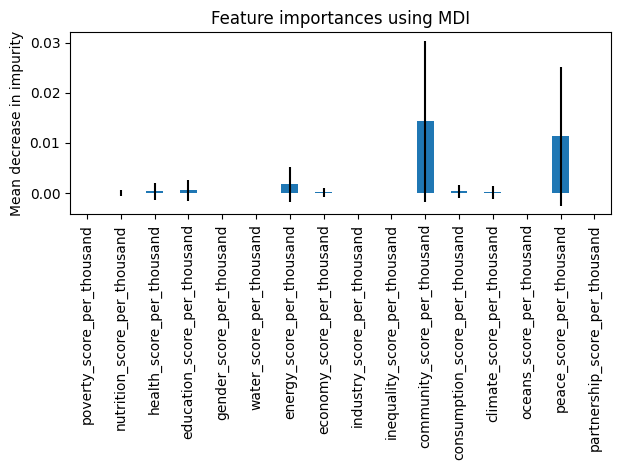

In [376]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=dependent_variables)

forest_importances = forest_importances[:16]
std = std[:16]

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [375]:
std

array([0.        , 0.00060611, 0.00167536, 0.00207029, 0.        ,
       0.        , 0.00347523, 0.00094121, 0.        , 0.        ,
       0.01610208, 0.00138012, 0.00133461, 0.        , 0.01385492,
       0.        , 0.0173608 , 0.        , 0.01305025, 0.        ,
       0.00645955, 0.02277522])